## Imports and config

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [67]:
import pandas as pd
import numpy as np
import partridge as ptg
import datetime
import os
import matplotlib.pyplot as plt

#import gtfs_utils as gu
#import gtfstk


In [4]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Read files

In [5]:
import glob
rs = (pd.concat([pd.read_pickle(f, compression='gzip') 
                 for f in glob.glob('data\\gtfs_stats_MOD_ffill\\2018-07*_route_stats.pkl.gz')] + 
                [pd.read_pickle(f, compression='gzip') 
                 for f in glob.glob('data\\gtfs_stats_MOD_ffill\\2018-08*_route_stats.pkl.gz')])
      .assign(date = lambda x: pd.to_datetime(x.date))
      .assign(dayofweek = lambda x: x['date'].dt.strftime('%A')))

In [6]:
rs.shape

(229087, 37)

In [7]:
rs.head().T

,0,1,2,3,4
route_id,1,10,10000,10001,10002
route_short_name,1,4,91,91,92
agency_id,25,25,14,14,14
agency_name,אפיקים,אפיקים,נתיב אקספרס,נתיב אקספרס,נתיב אקספרס
route_long_name,ת. רכבת יבנה מערב-יבנה<->ת. רכבת יבנה מזרח-יבנ...,ת. רכבת יבנה מזרח-יבנה<->ת. רכבת יבנה מערב-יבנ...,קופת חולים/הנשיא-צפת<->דרך חטיבת יפתח-צפת-11,האר''י/ישראל ב''ק-צפת<->שפרינצק/קרן היסוד-צפת-2#,געתון/מירון-כפר ורדים<->בית ספר כפר ורדים-כפר ...
route_type,3,3,3,3,3
num_trips,26,35,1,4,1
num_trip_starts,26,35,1,4,1
num_trip_ends,26,35,1,4,1
is_loop,0,0,0,0,0


In [71]:
route_sn = ['412', '980', '111', '460', '461', '701', '605']
route_sn = ['910']
rs[rs.route_short_name.isin(route_sn)].drop_duplicates(subset=['route_short_name', 'route_long_name', 'agency_id', 'start_zone', 'end_zone'])

,route_id,route_short_name,agency_id,agency_name,route_long_name,route_type,num_trips,num_trip_starts,num_trip_ends,is_loop,...,start_stop_lon,end_stop_lat,end_stop_lon,num_stops,start_zone,end_zone,num_zones,num_zones_missing,date,dayofweek
4983,7189,910,3,אגד,ת.מרכזית ת''א ק.7/רציפים-תל אביב יפו<->ת. מרכז...,3,14,14,14,0,...,34.780031,32.793368,34.959587,22,גוש דן,סובב חיפה,6,0,2018-07-01,Sunday
4985,7190,910,3,אגד,ת.מרכזית ת''א ק.7/רציפים-תל אביב יפו<->ת. רכבת...,3,1,1,0,0,...,34.780031,32.793065,34.957647,22,גוש דן,סובב חיפה,6,0,2018-07-01,Sunday
4986,7192,910,3,אגד,ת. מרכזית חוף הכרמל/רציפים בינעירוני-חיפה<->ת....,3,19,19,18,0,...,34.958985,32.055512,34.780335,23,סובב חיפה,גוש דן,6,0,2018-07-01,Sunday


In [72]:
route_ids = ['10953', '10954', '11178', '11179', '11941', '11942',
             '15544', '15545', '21331', '21332', '23451', '23452',
             '711', '712', '713', '714', '715', '21994',
             '15383', '19733', '7189', '7190', '7192']

test = rs[rs.route_id.isin(route_ids)]
nums = test.groupby(['route_short_name', 'date']).num_trips.sum().to_frame().unstack(level=0).reset_index()
nums = nums.assign(dayofweek = lambda x: x['date'].dt.strftime('%A'))
nums =nums[~nums.dayofweek.isin(['Friday', 'Saturday'])].set_index('date').drop(columns='dayofweek', axis=0)
nums.columns = nums.columns.droplevel(0)

nums.fillna(0)

route_short_name,111,412,460,461,605,701,900,910,980
date,,,,,,,,,
2018-07-01,90.0,40.0,32.0,60.0,139.0,0.0,0.0,34.0,0.0
2018-07-02,90.0,40.0,32.0,60.0,139.0,0.0,0.0,31.0,0.0
2018-07-03,90.0,40.0,32.0,60.0,139.0,0.0,0.0,31.0,0.0
2018-07-04,90.0,40.0,32.0,60.0,139.0,0.0,0.0,31.0,0.0
2018-07-05,90.0,40.0,32.0,60.0,139.0,0.0,0.0,31.0,0.0
2018-07-08,90.0,40.0,32.0,60.0,160.0,0.0,0.0,36.0,0.0
2018-07-09,90.0,40.0,32.0,60.0,159.0,0.0,0.0,31.0,0.0
2018-07-10,90.0,40.0,32.0,60.0,159.0,0.0,0.0,31.0,0.0
2018-07-11,90.0,40.0,32.0,60.0,159.0,0.0,0.0,31.0,0.0


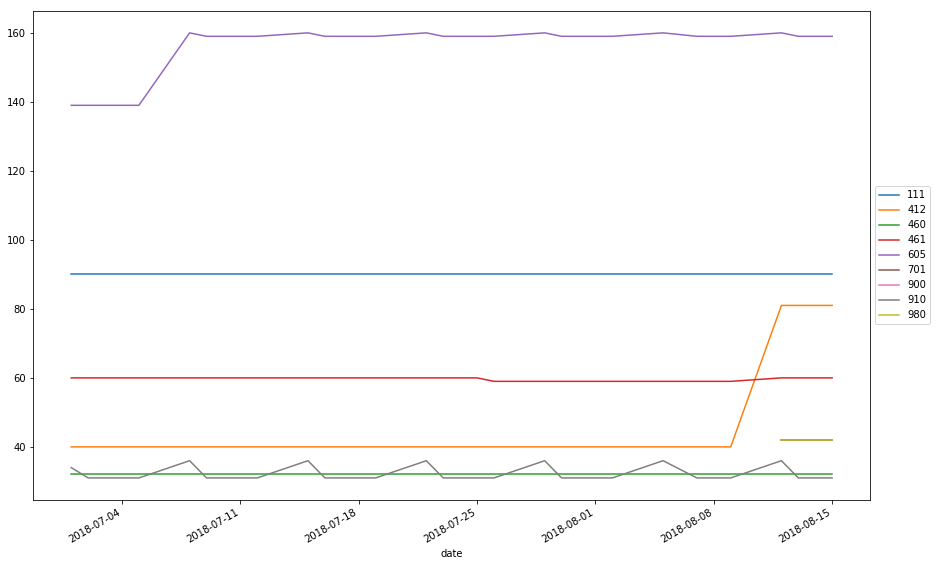

In [73]:
nums.plot(figsize=(15,10))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

לפי הלו"ז הרשמי של משרד התחבורה, מתוך 7 הקווים שהצהירו שיתוגברו בעקבות השיבושים ברכבות - רק 2 תוגברו באמת (980 ו-412).

מה עם כל השאר? לא צריך לעדכן ת'לוז? מאלתרים? מה התדירות החדשה? מתי הנסיעות?

למי שמתעניין, מזהי הקווים: 10953, 10954, 11178, 11179, 11941, 11942, 15544, 15545, 21331, 21332, 23451, 23452, 711, 712, 713, 714, 715, 